<a href="https://colab.research.google.com/github/KajetanFrackowiak/freeCodeCamp/blob/main/Copy_of_fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2023-10-26 18:02:47--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  80.6MB/s    in 0.3s    

2023-10-26 18:02:48 (80.6 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [ ]:
# Merging the dataframes
df = df_ratings.merge(df_books, on="isbn", how="left")

<Axes: title={'center': 'title'}, xlabel='Number of rieviews per book', ylabel='Frequency of rieviews per book'>

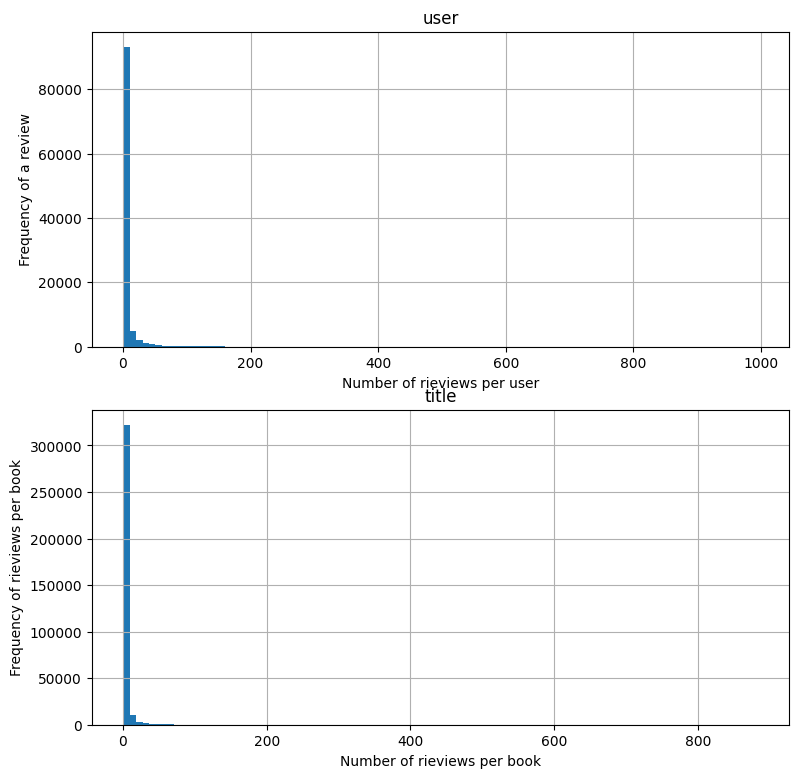

In [ ]:
# Plotting the dataset for exploratory analysis
fig, axes = plt.subplots(2, 1, figsize=(9, 9))
axes[0].set_title("user")
axes[0].set_xlabel("Number of rieviews per user")
axes[0].set_ylabel("Frequency of a review")
axes[1].set_title("title")
axes[1].set_xlabel("Number of rieviews per book")
axes[1].set_ylabel("Frequency of rieviews per book")
user_unique=df["user"].value_counts()
user_unique[user_unique<1000].hist(bins=100, ax = axes[0])
isbn_unique= df["isbn"].value_counts()
isbn_unique[isbn_unique<1000].hist(bins=100, ax = axes[1])

In [ ]:
# Selecting indices of books with more than 100 reviews and users with more than
# 200 reviews.
user_unique = user_unique[user_unique >= 200].index
isbn_unique = isbn_unique[isbn_unique >= 100].index

In [ ]:
# Filtering the dataset for to ensure statistical significance.
df_f = df.loc[(df["user"].isin(user_unique.values)) & (df["isbn"].isin(isbn_unique.values))]

In [ ]:
# Checking one example of duplicated entries in the dataframe.
# In some cases one user has review the same book with two or more different
# ISBN.
df_f.loc[(df_f["user"]==11676) & (df_f["title"]=='The Summons')]

,user,isbn,rating,title,author
48820,11676,0385503822,8.0,The Summons,John Grisham
49833,11676,0440241073,8.0,The Summons,John Grisham


In [ ]:
# Droping of duplicates
df_f = df_f.drop_duplicates(['title', 'user'])

In [ ]:
# Rearranging the data in a sparse matrix for using it as input for the model.
df_p = df_f.pivot(index = 'title', columns = 'user', values = 'rating').fillna(0)
df_m = csr_matrix(df_p.values)

In [ ]:
# Creating and training the model
neigh = NearestNeighbors(metric='cosine')
neigh.fit(df_m)

NearestNeighbors(metric='cosine')

In [ ]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
    recommended_books = [book,[]]
    dist,idx = neigh.kneighbors([df_p.loc[book]], 6, return_distance=True)

    recom_str = df_p.iloc[np.flip(idx[0])[:-1]].index.to_list()
    recom_dist = list(np.flip(dist[0])[:-1])
    for r in zip(recom_str,recom_dist):
        recommended_books[1].append(list(r))

    return recommended_books

In [ ]:
# Test the suggested example
get_recommends('The Queen of the Damned (Vampire Chronicles (Paperback))')

['The Queen of the Damned (Vampire Chronicles (Paperback))',
 [['Catch 22', 0.7939835],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.74486566],
  ['Interview with the Vampire', 0.73450685],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.53763384],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.51784116]]]

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
